In [1]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.preprocessing import sequence
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Conv1D,MaxPooling1D
from keras.layers.core import Dense, Activation,Dropout ,Flatten
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.constraints import maxnorm

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seed = 120
np.random.seed(seed)

In [3]:
train_path = './data/train/train_book_restaurant.csv'
train_df = pd.read_csv(train_path)# Loading a csv file with headers 
train_df.head()

,sentence_index,word,tag
0,0,book,O
1,0,The Middle East,restaurant_name
2,0,restaurant,restaurant_type
3,0,in,O
4,0,IN,state


In [4]:
class SentenceGetter(object):
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
getter = SentenceGetter(train_df)
sentences = getter.sentences
# 1st sentence 
print(sentences[0:1])

[[('book', 'O'), ('The Middle East', 'restaurant_name'), ('restaurant', 'restaurant_type'), (' in', 'O'), ('IN', 'state'), (' for', 'O'), ('noon', 'timeRange')]]


In [6]:
maxlen = max([len(s) for s in sentences])
print ('max length:', maxlen)

max length: 13


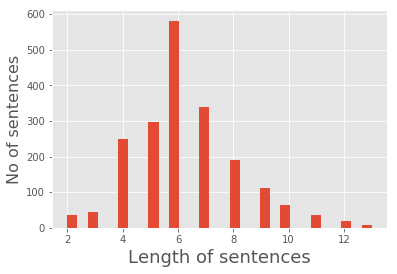

In [7]:
# Check how long sentences are so that we can pad them
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=30)

plt.xlabel('Length of sentences', fontsize=18)
plt.ylabel('No of sentences', fontsize=16)
plt.show()

In [10]:
# Getting unique list of words

words = list(set(train_df["word"].values))
words.append("ENDPAD")

n_words = len(words)
print("words:",n_words)

tags = list(set(train_df["tag"].values))
n_tags = len(tags)
print(tags)
if n_tags>maxlen:
    maxlen = n_tags

words: 3221
['sort', 'party_size_description', 'restaurant_name', 'served_dish', 'restaurant_type', 'O', 'poi', 'state', 'timeRange', 'country', 'city', 'cuisine', 'party_size_number', 'spatial_relation', 'facility']


In [11]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx =  {t: i for i, t in enumerate(tags)}
print("Word to index:",word2idx)

Word to index: {'Elma': 0, 'Brookneal': 1, 'northeastern brazilian': 2, 'this winter': 3, 'bessie, antonia and lisa': 4, 'in two hundred thirty seven days': 5, 'Fraser Mansion': 6, 'Guinea': 7, 'south american': 8, ' to eat in': 9, ' person at': 10, 'me, winnie and courtney': 11, 'I want to book an': 12, 'tuscan': 13, 'irene and rosella': 14, "D'Iberville": 15, 'I need reservations for a party of': 16, 'casey chavez, lucinda and karina': 17, 'Cleveland': 18, ' please.': 19, 'kristina and teresa': 20, 'The Cherry Street Tavern': 21, 'not far': 22, ' which has a': 23, 'my boss and I': 24, 'pizzeria': 25, 'book a spot that is': 26, 'Canteen Lunch in the Alley': 27, 'McColl': 28, ' time in': 29, 'bucatini': 30, 'Last Exit on Brooklyn': 31, 'Henlopen Acres': 32, 'bread': 33, 'Grenada': 34, 'Saint Barthélemy': 35, 'in a month': 36, 'Bermuda': 37, 'Iraq': 38, 'Please book reservations at a': 39, 'Ely': 40, 'November 24, 2036': 41, 'VA': 42, 'Bridge Round House': 43, 'I need a reservation, loo

In [13]:
tag2idx

{'O': 5,
 'city': 10,
 'country': 9,
 'cuisine': 11,
 'facility': 14,
 'party_size_description': 1,
 'party_size_number': 12,
 'poi': 6,
 'restaurant_name': 2,
 'restaurant_type': 4,
 'served_dish': 3,
 'sort': 0,
 'spatial_relation': 13,
 'state': 7,
 'timeRange': 8}

In [14]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)


In [15]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print("Before padding:",y[0])
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
print("After padding:",y[0])
print("Categorical Data:")
y = [to_categorical(i, num_classes=n_tags) for i in y]
print(y[0])
print(y[0].shape)

Before padding: [5, 2, 4, 5, 7, 5, 8]
After padding: [5 2 4 5 7 5 8 5 5 5 5 5 5 5 5]
Categorical Data:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(15, 15)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
print(n_words)

3221


### 11. Neural Network Model

In [18]:
#model
model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=15, input_length=15)) #to change words to ints

model.add(Dropout(0.1))
model.add(Dense(1200, activation='relu',W_constraint=maxnorm(1)))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.summary()

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1200, activation="relu", kernel_constraint=<keras.con...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 15)            48315     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 15, 1200)          19200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 200)           1040800   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 15)            3015      
Total params: 1,111,330
Trainable params: 1,111,330
Non-trainable params: 0
_________________________________________________________________


In [19]:
# input = Input(shape=(13,))
# model = Embedding(input_dim=n_words, output_dim=13, input_length=13)(input)
# model = Dropout(0.1)(model)
# model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
# model = Model(input, out)
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=35, validation_split=0.2, verbose=1)

Train on 1262 samples, validate on 316 samples
Epoch 1/35
1262/1262 [==============================] - 5s 4ms/step - loss: 1.3216 - acc: 0.7649 - val_loss: 0.9356 - val_acc: 0.7757
Epoch 2/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.8444 - acc: 0.7848 - val_loss: 0.8222 - val_acc: 0.7757
Epoch 3/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.6685 - acc: 0.8067 - val_loss: 0.5814 - val_acc: 0.8245
Epoch 4/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.4438 - acc: 0.8563 - val_loss: 0.4165 - val_acc: 0.8665
Epoch 5/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.3039 - acc: 0.9016 - val_loss: 0.3257 - val_acc: 0.8956
Epoch 6/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.2225 - acc: 0.9307 - val_loss: 0.2869 - val_acc: 0.9171
Epoch 7/35
1262/1262 [==============================] - 2s 1ms/step - loss: 0.1587 - acc: 0.9582 - val_loss: 0.2690 - val_acc: 0.9262
Epoch 8/35
1262

In [21]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=1)
print('Test accuracy:', score[1],'%')


395/395 [==============================] - 0s 487us/step
Test accuracy: 0.9417721550675887 %


In [22]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

Restaurant     : restaurant_type
 in            : O
Brokaw         : party_size_description
 for a cuisine : party_size_description
russian        : cuisine
far            : spatial_relation
restaurant     : restaurant_type
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


In [23]:
sequences =[]
sentence = "Book a restaurant with parking facility for 3"
for word in sentence.split(" "):
    try:
        sequences.append(word2idx[word])
    except:
        sequences.append(word2idx['ENDPAD'])    
print(sequences)        
padded_sequence = pad_sequences(maxlen=maxlen, sequences=[sequences], padding="post",value=n_words - 1)
p = model.predict([padded_sequence])
p = np.argmax(p, axis=-1)
tag_list = []
for i in p:
    for j in i:
        tag_list.append(j)
print(tag_list)
for i in p:
    count = 0
    for j in sentence.split():
        print("Word:",j,"             ","Tag:",tags[tag_list[count]])
        count = count + 1

[506, 3220, 2474, 3220, 3191, 3220, 3220, 822]
[5, 5, 4, 5, 14, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5]
Word: Book               Tag: O
Word: a               Tag: O
Word: restaurant               Tag: restaurant_type
Word: with               Tag: O
Word: parking               Tag: facility
Word: facility               Tag: O
Word: for               Tag: O
Word: 3               Tag: party_size_number
